In [2]:
import multiprocessing
import time
import random
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import mxnet as mx
import numpy as np
from skimage.draw import line_aa
from skimage import transform as tf

from mxnet import nd, autograd, gluon
from mxnet.image import resize_short
from mxboard import SummaryWriter

ctx = mx.gpu()
mx.random.seed(1)

from utils.iam_dataset import IAMDataset
from utils.iou_loss import IOU_loss
from utils.draw_box_on_image import draw_box_on_image

MODEL_CHECKPOINT_FOLDER = "model_checkpoint"
if not os.path.isdir(MODEL_CHECKPOINT_FOLDER):
    os.makedirs(MODEL_CHECKPOINT_FOLDER)

# Paragraph Segmentation
This notebook investigates methods to identify segment handwritten passages from images that contains printed and handwritten text using **DCNN**

*Input*: a png from the IAM dataset with the "form" input and output type of "bb" and form.

*Output*: a bounding boxes of the paragraphs.

## Dataset creation

In [3]:
train_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=True)
print("Number of training samples: {}".format(len(train_ds)))

test_ds = IAMDataset("form", output_data="bb", output_parse_method="form", train=False)
print("Number of testing samples: {}".format(len(test_ds)))

Number of training samples: 967
Number of testing samples: 232


Two transforms were used, the "transform" function only resizes and normalises the image. The "augment_transform" function randomly shifts the image and predicted bounding box by 5% then called the "transform" function.

In [4]:
batch_size = 32

def transform(data, label):
    image = mx.nd.array(data).expand_dims(axis=2)
    image = resize_short(image, int(800/3))
    image = image.transpose([2, 0, 1])/255.
    label = label[0].astype(np.float32)
    return image, mx.nd.array(label)

def augment_transform(data, label):
    width_translation_range = 0.05
    height_translation_range = 0.05

    ty = random.uniform(-height_translation_range, height_translation_range)
    tx = random.uniform(-width_translation_range, width_translation_range)
    st = tf.SimilarityTransform(translation=(tx*data.shape[1], ty*data.shape[0]))
    data = tf.warp(data, st)

    label[0][0] = label[0][0] - tx
    label[0][1] = label[0][1] - ty

    return transform(data*255., label)

In [5]:
train_data = gluon.data.DataLoader(train_ds.transform(augment_transform), batch_size, shuffle=True, num_workers=multiprocessing.cpu_count())
test_data = gluon.data.DataLoader(test_ds.transform(transform), batch_size, shuffle=False, num_workers=multiprocessing.cpu_count())

## Network creation

In [6]:
def make_cnn():
    p_dropout = 0.5

    cnn = gluon.nn.HybridSequential()
    cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=16, activation="relu"))
    cnn.add(gluon.nn.BatchNorm())

    cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=16, activation="relu"))
    cnn.add(gluon.nn.BatchNorm())

    cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=16, activation="relu"))
    cnn.add(gluon.nn.BatchNorm())

    cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=16, activation="relu"))
    cnn.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
    cnn.add(gluon.nn.BatchNorm())

    cnn.add(gluon.nn.Conv2D(kernel_size=(3,3), padding=(1,1), channels=16, activation="relu"))
    cnn.add(gluon.nn.MaxPool2D(pool_size=(2,2), strides=(2,2)))
    cnn.add(gluon.nn.BatchNorm())

    cnn.add(gluon.nn.Flatten())
    cnn.add(gluon.nn.Dense(64, activation='relu'))
    cnn.add(gluon.nn.Dropout(p_dropout))
    cnn.add(gluon.nn.Dense(64, activation='relu'))
    cnn.add(gluon.nn.Dropout(p_dropout))
    cnn.add(gluon.nn.Dense(4, activation='sigmoid'))

    cnn.hybridize()
    cnn.collect_params().initialize(mx.init.Normal(), ctx=ctx)
    return cnn

cnn = make_cnn()

## Pre training
The network was initially trained on 300 epochs using the Mean squared error (L2 loss) as a loss function. This was performed because without reasonable bounding boxes (ie. overlapping bounding boxes), the IOU loss will not function properly. 

In [7]:
l2_loss = gluon.loss.L2Loss()
LEARNING_RATE = 0.001
trainer = gluon.Trainer(cnn.collect_params(), 'adam', {'learning_rate': LEARNING_RATE, })
epochs = 301
print_every_n = 20
send_image_every_n = 20
save_every_n = 100

for e in range(epochs):    
    loss = nd.zeros(1, ctx)
    test_loss = nd.zeros(1, ctx)
    tick = time.time()
    acc = nd.zeros(1, ctx)
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        with autograd.record():
            output = cnn(data)
            loss_l2 = l2_loss(output, label)
        loss_l2.backward()
        loss += loss_l2.mean()
        
        trainer.step(data.shape[0])
        if e % send_image_every_n == 0 and e > 0 and i == 0:
            output = cnn(data)
            data_np = data.asnumpy()
            label_np = label.asnumpy()
            pred_np = output.asnumpy()
            train_output_image = draw_box_on_image(pred_np, label_np, data_np)

    for i, (data, label) in enumerate(test_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = cnn(data)
            test_loss_l2 = l2_loss(output, label)
        test_loss += test_loss_l2.mean()
        
        # Generate images of the first batch
        if e % send_image_every_n == 0 and e > 0 and i == 0:
            output = cnn(data)
            data_np = data.asnumpy()
            label_np = label.asnumpy()
            pred_np = output.asnumpy()
            test_output_image = draw_box_on_image(pred_np, label_np, data_np)

    train_loss = float(loss.asscalar())/len(train_data)
    test_loss = float(test_loss.asscalar())/len(test_data)
    
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, val_loss {2:.6f}".format(
            e, train_loss, test_loss))
    
    with SummaryWriter(logdir='./logs', verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {"train": train_loss, "test": test_loss}, global_step=e)
        if e % send_image_every_n == 0 and e > 0:
            train_output_image[train_output_image<0] = 0
            train_output_image[train_output_image>1] = 1

            test_output_image[test_output_image<0] = 0
            test_output_image[test_output_image>1] = 1
            sw.add_image('bb_train_image', train_output_image, global_step=e)
            sw.add_image('bb_test_image', test_output_image, global_step=e)

    if e % save_every_n == 0 and e > 0:
        cnn.save_params("model_checkpoint/cnn{}.params".format(e))

Epoch 20, train_loss 0.002157, val_loss 0.002758
Epoch 40, train_loss 0.001558, val_loss 0.002137
Epoch 60, train_loss 0.001057, val_loss 0.001436
Epoch 80, train_loss 0.000848, val_loss 0.001070
Epoch 100, train_loss 0.000645, val_loss 0.000858
Epoch 120, train_loss 0.000556, val_loss 0.000812
Epoch 140, train_loss 0.000524, val_loss 0.000588
Epoch 160, train_loss 0.000504, val_loss 0.000449
Epoch 180, train_loss 0.000457, val_loss 0.000599
Epoch 200, train_loss 0.000462, val_loss 0.000510
Epoch 220, train_loss 0.000455, val_loss 0.000581
Epoch 240, train_loss 0.000426, val_loss 0.000569
Epoch 260, train_loss 0.000425, val_loss 0.000474
Epoch 280, train_loss 0.000387, val_loss 0.000414
Epoch 300, train_loss 0.000399, val_loss 0.000379


### Fine tuning
After training the network with the mean squared error loss, the IOU loss was used to fine tune the network. The IOU loss is more finegrained as it maximises the overlap between the bounding boxes.

In [8]:
cnn.load_params("model_checkpoint/cnn300.params")

In [9]:
iou_loss = IOU_loss()
LEARNING_RATE = 0.0001
trainer = gluon.Trainer(cnn.collect_params(), 'adam', {'learning_rate': LEARNING_RATE, })

epochs = 120
print_every_n = 20
send_image_every_n = 20
save_every_n = 100

for e in range(epochs):    
    loss = nd.zeros(1, ctx)
    test_loss = nd.zeros(1, ctx)
    tick = time.time()
    acc = nd.zeros(1, ctx)
    for i, (data, label) in enumerate(train_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        
        with autograd.record():
            output = cnn(data)
            loss_iou = iou_loss(output, label)
        loss_iou.backward()
        loss += loss_iou.mean()
        
        trainer.step(data.shape[0])
        if e % send_image_every_n == 0 and e > 0 and i == 0:
            output = cnn(data)
            data_np = data.asnumpy()
            label_np = label.asnumpy()
            pred_np = output.asnumpy()
            train_output_image = draw_box_on_image(pred_np, label_np, data_np)

    for i, (data, label) in enumerate(test_data):
        data = data.as_in_context(ctx)
        label = label.as_in_context(ctx)
        with autograd.record():
            output = cnn(data)
            test_loss_iou = iou_loss(output, label)
        test_loss += test_loss_iou.mean()
        
        # Generate images of the first batch
        if e % send_image_every_n == 0 and e > 0 and i == 0:
            output = cnn(data)
            data_np = data.asnumpy()
            label_np = label.asnumpy()
            pred_np = output.asnumpy()
            test_output_image = draw_box_on_image(pred_np, label_np, data_np)

    train_loss = float(loss.asscalar())/len(train_data)
    test_loss = float(test_loss.asscalar())/len(test_data)
    
    if e % print_every_n == 0 and e > 0:
        print("Epoch {0}, train_loss {1:.6f}, val_loss {2:.6f}".format(
            e, train_loss, test_loss))
    
    with SummaryWriter(logdir='./logs', verbose=False, flush_secs=5) as sw:
        sw.add_scalar('loss', {"train": train_loss, "test": test_loss}, global_step=e)
        if e % send_image_every_n == 0 and e > 0:
            train_output_image[train_output_image<0] = 0
            train_output_image[train_output_image>1] = 1

            test_output_image[test_output_image<0] = 0
            test_output_image[test_output_image>1] = 1
            sw.add_image('bb_train_image', train_output_image, global_step=e)
            sw.add_image('bb_test_image', test_output_image, global_step=e)

    if e % save_every_n == 0 and e > 0:
        cnn.save_params("model_checkpoint/cnn_iou{}.params".format(e))

Epoch 20, train_loss 0.146999, val_loss 0.155457
Epoch 40, train_loss 0.150869, val_loss 0.153650
Epoch 60, train_loss 0.142351, val_loss 0.148853
Epoch 80, train_loss 0.141588, val_loss 0.167002
Epoch 100, train_loss 0.147602, val_loss 0.166904


## Results
The training and test MSE is printed out in this notebook. The loss and the images with predicted bounding boxes is shown on below. Both this information can be viewed on [mxboard](https://medium.com/apache-mxnet/mxboard-mxnet-data-visualization-2eed6ae31d2c) while the network is training. 

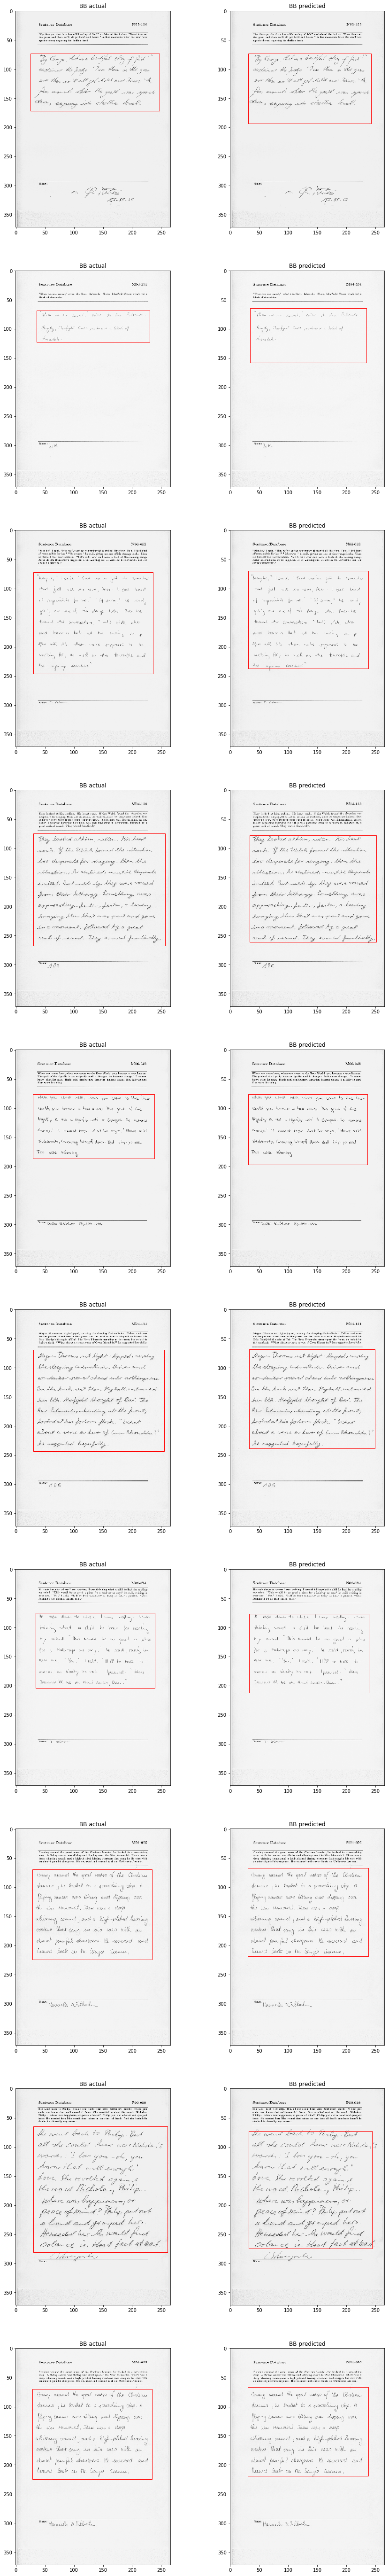

In [12]:
figs_to_plot = 10
fig, axs = plt.subplots(figs_to_plot, 2, figsize=(15, 10 * figs_to_plot))

for i in range(figs_to_plot):
    n = int(random.random()*len(test_ds))
    image, bb = test_ds[n]

    image, _ = transform(image, bb)
    image = image.as_in_context(ctx)
    image = image.expand_dims(axis=0)
    bb_predicted = cnn(image)

    (x, y, w, h) = bb[0]
    axs[i][0].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[i][0].add_patch(rect)
    axs[i][0].set_title("BB actual")

    axs[i][1].imshow(image.asnumpy().squeeze(), cmap='Greys_r')
    (x, y, w, h) = bb_predicted[0].asnumpy()
    image_h, image_w = image.shape[-2:]
    (x, y, w, h) = (x * image_w, y * image_h, w * image_w, h * image_h)
    rect = patches.Rectangle((x, y), w, h, fill=False, color="r")
    axs[i][1].add_patch(rect)
    axs[i][1].set_title("BB predicted")
